In [1]:
import numpy as np
import pandas as pd
from scipy.io import wavfile
import joblib
import seaborn as sns
#%matplotlib tk
%matplotlib qt
%autosave 180
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from pylab import specgram
from scipy.signal import argrelmax
from scipy.stats import linregress, pearsonr
import os

#%pylab inline

Autosaving every 180 seconds


In [2]:
# MAKE 2D SURFACE FROM 1D ARRAYS

def make_3D_surface(lengths, r2_final, k, plotting=False):
    
    # select array
    r2_array_fit = r2_final[k]
    
    # 
    surface = np.zeros((lengths[0]*4, lengths[1]*4),'float32')
    #print (surface.shape)

    for k in range(len(r2_array_fit)):
        #print (k,r2_array_fit[k].shape)
        if r2_array_fit[k].shape[0]==2080:
            for p in range(r2_array_fit[k].shape[0]):
                surface[p]+=r2_array_fit[k][p]/np.max(r2_array_fit[k])
        else:
            for p in range(r2_array_fit[k].shape[0]):
                surface[:,p]+=r2_array_fit[k][p]/np.max(r2_array_fit[k])

    scale = 10
    if plotting:
        ticks_old = np.arange(0,surface.shape[0],6.51)[::scale]
        ticks_new = np.arange(0,ticks_old.shape[0],1)*scale
        plt.yticks(ticks_old, ticks_new,fontsize=10)

    if plotting:
        ticks_old = np.arange(0,surface.shape[1],6.51)[::scale]
        ticks_new = np.arange(0,ticks_old.shape[0],1)*scale
        plt.xticks(ticks_old,ticks_new,fontsize=10,rotation=45)


    idx = np.max(surface)
    #print (idx)

    idx3 = np.where(surface==idx)
    #print (idx3)


    idx4 = np.where(surface<np.max(surface)*0.0)
    surface_updated = surface.copy()
    surface_updated[idx4]=0

    if plotting:
        plt.imshow(surface_updated,cmap='viridis')

        plt.scatter(idx3[1],idx3[0],s=100,c='red')

        plt.xlabel("Length in (cms)")
        plt.ylabel("Width in (cms)")
        plt.suptitle(fname,fontsize=20)
    #plt.show()

    print ("mic location: ", k, '  inferred centre: ', idx3[1],idx3[0])
    
    return (idx3[1],idx3[0])



def correlate_raw_signal(lengths, mics, plotting=False):
    from scipy import signal
    import numpy.polynomial.polynomial as poly
    
    #lengths = np.array([260,390,260,390])*2
    offset = np.max(lengths)*2

    r2_array =[]
    r2_array_fit = []
    #for k in range(len(lengths)):
    for k in range(4):
        
        if plotting:
            ax=plt.subplot(2,2,k+1)
        r2 = []
        window = lengths[k]*2

        mic1 = mics[(k+1)%4][offset:-window*2].copy()
        #print ("mic1: ", mic1.shape)
        
        if False:
            mic1[:15000]=0
            #mic1[18500:]=0
            #pass
            
        # compute correlation across raw signal
        for i in range(-window, window,1):
            #call_padded = np.append(mics[k], [0]*i)[i:]
            mic0 = mics[k][offset+i:+i-window*2].copy()
            #print (mic0.shape, mic1.shape)
            slope, intercept, r_value, p_value, std_err = linregress(mic0, mic1)
            r2.append(r_value**2)

        r2 = np.array(r2)
        r2_array.append(r2)
        idxes = argrelmax(r2, axis=0)
        idxes = np.array(idxes).squeeze()
        
        idx = np.argmax(r2)

        
        # Linear interpolation
        f = np.interp(np.arange(r2.shape[0]), idxes, r2[idxes])
        r2_array_fit.append(f)

        if plotting:
            plt.scatter(idxes,r2[idxes],c='blue')
            plt.scatter(idx,r2[idx],c='red')
            print ("Offset: ", -window+idx, " steps, ", (-window+idx)*0.000004, "secs" )


            #f = r2[idxes]
            plt.plot(np.arange(r2.shape[0]), f, c='green')

            # plot routines
            plt.plot(r2)
            plt.ylabel("mic"+str(k)+" and mic"+str((k+1)%4)+ 
                       "\nOffset: "+ str(-window+idx)+ " steps, "+ 
                       str(round((-window+idx)*0.000004,6))+ "secs",fontsize=15 )
    if plotting:
        plt.show()
    
    return np.array(r2_array_fit)



def correlate_envelope_signal(lengths, mics, plotting=False):
    from scipy import signal
    import numpy.polynomial.polynomial as poly
    from scipy.signal import hilbert, chirp

    #lengths = np.array([260,390,260,390])*2
    offset = np.max(lengths)*2

    r2_array =[]
    r2_array_fit = []
    #for k in range(len(lengths)):
    # loo over mics
    for k in range(4):
        
        if plotting:
            ax=plt.subplot(2,2,k+1)
        window = lengths[k]*2

        mic1 = mics[(k+1)%4][offset:-window*2].copy()
        #print ("mic1: ", mic1.shape)
        
        if False:
            mic1[:15000]=0
            #mic1[18500:]=0
            #pass

        #r2 = np.array(r2)
        #r2_array.append(r2)
        idxes = argrelmax(mic1, axis=0)
        idxes = np.array(idxes).squeeze()
        #fig = plt.figure(figsize=(10,10))

        #plt.plot(mic1,c='black')
        #plt.scatter(idxes,mic1[idxes],c='blue')
        
        # grab envelope:
        analytic_signal = hilbert(mic1)
        mic1_amplitude_envelope = np.abs(analytic_signal)
        #plt.plot(amplitude_envelope,c='cyan')
        
        # grab envelope:
        mic0 = mics[k][offset:-window*2].copy()
        analytic_signal = hilbert(mic0)
        mic0_amplitude_envelope = np.abs(analytic_signal)

            
        # compute correlation across raw signal
        r2 = []
        for i in range(-window, window,1):
            #call_padded = np.append(mics[k], [0]*i)[i:]
            
            mic0_in = np.roll(mic0_amplitude_envelope,i)
            #print (mic0.shape, mic1.shape)
            slope, intercept, r_value, p_value, std_err = linregress(mic0_in, mic1_amplitude_envelope)
            r2.append(r_value**2)
    
        r2 = np.array(r2)
        r2_array.append(r2)
#         idxes = argrelmax(r2, axis=0)
#         idxes = np.array(idxes).squeeze()
        
#         idx = np.argmax(r2)

        
#         # Linear interpolation
#         f = np.interp(np.arange(r2.shape[0]), idxes, r2[idxes])
#         r2_array_fit.append(f)
        
        if plotting:
            idx =np.argmax(r2)
            #plt.scatter(idxes,r2[idxes],c='blue')
            #plt.scatter(idx,r2[idx],c='red')
            print ("Offset: ", -window+idx, " steps, ", (-window+idx)*0.000004, "secs" )

            #f = r2[idxes]
            #plt.plot(np.arange(r2.shape[0]), f, c='green')

            # plot routines
            plt.plot(r2)
            plt.ylabel("mic"+str(k)+" and mic"+str((k+1)%4)+ 
                       "\nOffset: "+ str(-window+idx)+ " steps, "+ 
                       str(round((-window+idx)*0.000004,6))+ "secs",fontsize=15 )
    if plotting:
        plt.show()
    
    return np.array(r2_array)


def read_filter_data(fname, call_onset, call_offset, filter_data, plotting):

    # load data
    print ("Loading: ", fname)
    data = np.load(fname)
    mic0_audio = data[0]
    mic1_audio = data[1]
    mic2_audio = data[2]
    mic3_audio = data[3]
    
    # clip data 
    #print ("Clipping :", call_onset, call_offset)
    fs = 250000
    call_mic0 = mic0_audio[int(call_onset*fs):int(call_offset*fs)]
    call_mic1 = mic1_audio[int(call_onset*fs):int(call_offset*fs)]
    call_mic2 = mic2_audio[int(call_onset*fs):int(call_offset*fs)]
    call_mic3 = mic3_audio[int(call_onset*fs):int(call_offset*fs)]  


    nfft = 1024
    if plotting:
        fig=plt.figure()
        ax1=plt.subplot(4,2,1)
        pxx, freqs, bins, im = specgram(call_mic0, NFFT=nfft, Fs=fs, noverlap=nfft/2,
                                       clim=(-100,-80))
        plt.ylim(0,40000)
        plt.ylabel('mic 0')

        ax1=plt.subplot(4,2,3)
        pxx, freqs, bins, im = specgram(call_mic1, NFFT=nfft, Fs=fs, noverlap=nfft/2,
                                       clim=(-100,-80))
        plt.ylim(0,40000)
        plt.ylabel('mic 1')

        ax1=plt.subplot(4,2,5)
        pxx, freqs, bins, im = specgram(call_mic2, NFFT=nfft, Fs=fs, noverlap=nfft/2,
                                       clim=(-100,-80))
        plt.ylim(0,40000)
        plt.ylabel('mic 2')

        ax1=plt.subplot(4,2,7)
        pxx, freqs, bins, im = specgram(call_mic3, NFFT=nfft, Fs=fs, noverlap=nfft/2,
                                       clim=(-100,-80))
        plt.ylim(0,40000)
        plt.ylabel('mic 3')

    # filter data
    start_fs = 6500
    end_fs = 7500
    mic0_audio_bp = butter_bandpass_filter(call_mic0, start_fs, end_fs, fs)  # YOU CAN AUTODETECT THIS
    mic1_audio_bp = butter_bandpass_filter(call_mic1, start_fs, end_fs, fs)
    mic2_audio_bp = butter_bandpass_filter(call_mic2, start_fs, end_fs, fs)
    mic3_audio_bp = butter_bandpass_filter(call_mic3, start_fs, end_fs, fs)

    if plotting:
        ax2=plt.subplot(4,2,2)
        pxx, freqs, bins, im = specgram(mic0_audio_bp, NFFT=nfft, Fs=fs, noverlap=nfft/2,
                                       clim=(-100,-80))
        plt.ylim(0,40000)

        ax2=plt.subplot(4,2,4)
        pxx, freqs, bins, im = specgram(mic1_audio_bp, NFFT=nfft, Fs=fs, noverlap=nfft/2,
                                       clim=(-100,-80))
        plt.ylim(0,40000)

        ax2=plt.subplot(4,2,6)
        pxx, freqs, bins, im = specgram(mic2_audio_bp, NFFT=nfft, Fs=fs, noverlap=nfft/2,
                                       clim=(-100,-80))
        plt.ylim(0,40000)

        ax2=plt.subplot(4,2,8)
        pxx, freqs, bins, im = specgram(mic3_audio_bp, NFFT=nfft, Fs=fs, noverlap=nfft/2,
                                       clim=(-100,-80))
        plt.ylim(0,40000)

        plt.suptitle(os.path.split(fname)[1])
    
    if filter_data:
        return (mic0_audio_bp, mic1_audio_bp, mic2_audio_bp, mic3_audio_bp)
    else:
        return (call_mic0, call_mic1, call_mic2, call_mic3)
    
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y



In [16]:
# COMPUTE SHIFT CORRELATION AND FIT POLYNOMIAL

# filenames = ['/media/cat/4TBSSD/Downloads/2020-07-10_20_05_40.673203_audio_A.npy',
#              '/media/cat/4TBSSD/Downloads/2020-07-10_20_06_22.532042_audio_B.npy',
#              '/media/cat/4TBSSD/Downloads/2020-07-10_20_07_19.409833_audio_C.npy',
#              '/media/cat/4TBSSD/Downloads/2020-07-10_20_08_02.677607_audio_D.npy',
#              '/media/cat/4TBSSD/Downloads/2020-07-10_20_09_07.645162_audio_E.npy',
            
#               '/media/cat/4TBSSD/Downloads/2020-07-10_20_01_52.787211_audio_pos1.npy',
#               '/media/cat/4TBSSD/Downloads/2020-07-10_20_03_05.256554_audio_pos5.npy',
#               '/media/cat/4TBSSD/Downloads/2020-07-10_20_04_20.196753_audio_pos11.npy',
#               '/media/cat/4TBSSD/Downloads/2020-07-10_20_03_42.148538_audio_pos15.npy',
#              ]

filenames = [
    r'E:\july10_pos8A\audio\2020-07-10_20_05_40.673203_audio.npy',
    r'E:\july10_pos8B\audio\2020-07-10_20_06_22.532042_audio.npy',
    r'E:\july10_pos8C\audio\2020-07-10_20_07_19.409833_audio.npy',
    r'E:\july10_pos8D\audio\2020-07-10_20_08_02.677607_audio.npy',
    r'E:\july10_pos8E\audio\2020-07-10_20_09_07.645162_audio.npy',
    
    r'E:\july10_pos1\audio\2020-07-10_20_01_52.787211_audio.npy',
    r'E:\july10_pos5\audio\2020-07-10_20_03_05.256554_audio.npy',
    r'E:\july10_pos11\audio\2020-07-10_20_04_20.196753_audio.npy',
    r'E:\july10_pos15\audio\2020-07-10_20_03_42.148538_audio.npy',
    
]


# box dimensions
width = 291
length = 438
lengths= [width, length, width, length]

call_onsets = [1.98, 
           1.99,
           1.99,
           1.99,
           1.99,
           1.99,
           1.99,
           1.99,
           1.99
          ]

call_offsets = [1.98+0.125,
            1.99+0.125,
            1.99+0.125,
            1.99+0.125,
            1.99+0.125,
            1.99+0.125,
            1.99+0.125,
            1.99+0.125,
            1.99+0.125               
           ] 

lengths = np.array([260,390,260,390])*2
offset = np.max(lengths)*2
print (lengths)

ctr=0
r2_final = []
for fname in filenames:
    plotting=False
    filter_data = True
    mics = read_filter_data(fname, call_onsets[ctr],call_offsets[ctr], filter_data, plotting)
    
    plotting=False
    r2_array_fit = correlate_envelope_signal(lengths, mics, plotting)
    print ("len r2 array: ", len(r2_array_fit))
    r2_final.append(r2_array_fit)
    ctr+=1

if plotting:
    plt.show()

np.save(r'E:\r2_final.npy',r2_final)
print ("DONE")

[520 780 520 780]
Loading:  E:\july10_pos8A\audio\2020-07-10_20_05_40.673203_audio.npy


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:211: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


len r2 array:  4
Loading:  E:\july10_pos8B\audio\2020-07-10_20_06_22.532042_audio.npy
len r2 array:  4
Loading:  E:\july10_pos8C\audio\2020-07-10_20_07_19.409833_audio.npy
len r2 array:  4
Loading:  E:\july10_pos8D\audio\2020-07-10_20_08_02.677607_audio.npy
len r2 array:  4
Loading:  E:\july10_pos8E\audio\2020-07-10_20_09_07.645162_audio.npy
len r2 array:  4
Loading:  E:\july10_pos1\audio\2020-07-10_20_01_52.787211_audio.npy
len r2 array:  4
Loading:  E:\july10_pos5\audio\2020-07-10_20_03_05.256554_audio.npy
len r2 array:  4
Loading:  E:\july10_pos11\audio\2020-07-10_20_04_20.196753_audio.npy
len r2 array:  4
Loading:  E:\july10_pos15\audio\2020-07-10_20_03_42.148538_audio.npy
len r2 array:  4
DONE


In [5]:
print (r2_final)

[array([], dtype=float64)]


In [4]:
np.save(r'E:\r2_final.npy',r2_final)

In [3]:
r2_final = np.load(r'E:\r2_final.npy',allow_pickle=True)

In [17]:
# MAKE 2D FIT SURFACES

print (r2_final[1].shape)
plotting = False
max_locs = []
for k in range(len(r2_final)):
#for k in range(1):
    if plotting:
        fig=plt.figure()
    max_loc = make_3D_surface(lengths, r2_final,k, plotting)
    max_locs.append(max_loc)
if plotting:
    plt.show()


(4,)
mic location:  3   inferred centre:  [1653] [972]
mic location:  3   inferred centre:  [1575] [1068]
mic location:  3   inferred centre:  [1557] [1067]
mic location:  3   inferred centre:  [1561] [1016]
mic location:  3   inferred centre:  [1559] [1058]
mic location:  3   inferred centre:  [1566] [1037]
mic location:  3   inferred centre:  [1560] [1200]
mic location:  3   inferred centre:  [1560] [1189]
mic location:  3   inferred centre:  [1566] [925]


In [42]:
# clrs=['black','blue','red','green','magenta']
# positions=['A','B','C','D','E', ]
# for k in range(len(max_locs)):
#     temp = np.float32(max_locs[k])*0.001372
#     plt.scatter(temp[0],temp[1], c=clrs[k], s=200, label="pos "+positions[k])
# plt.legend(fontsize=20)
# plt.ylabel("Width (Metres)",fontsize=20)
# plt.xlabel("Length (Metres)",fontsize=20)
# plt.show()
    

In [19]:
clrs=['black','blue','red','green','magenta', 'brown', 'cyan','yellow','darkblue']
positions=['pos8_A','pos8_B','pos8_C','pos8_D','pos8_E', 'pos1', 'pos5','pos11','pos15']
for k in range(len(max_locs)):
    temp = np.float32(max_locs[k])*0.001372
    print (k, temp.shape)
    temp=temp[:,0]
    plt.scatter(temp[0],temp[1], c=clrs[k], s=200)
    plt.text(temp[0],temp[1], positions[k])
# temp = np.float32(max_locs[0])*0.001372
# plt.scatter(temp[0],temp[1], c=clrs[-1], s=200, label=positions[-1])
    
#plt.legend(fontsize=20)
plt.ylabel("Width (Metres)",fontsize=20)
plt.xlabel("Length (Metres)",fontsize=20)
plt.show()
    

0 (2, 1)
1 (2, 1)
2 (2, 1)
3 (2, 1)
4 (2, 1)
5 (2, 1)
6 (2, 1)
7 (2, 1)
8 (2, 1)


In [ ]:
# OLD CODE

In [39]:
max_locs_pos8=np.array(max_locs).copy()
print (max_locs_pos8)

[[[1419]
  [1126]]

 [[1515]
  [ 975]]

 [[1549]
  [1035]]

 [[1535]
  [1113]]

 [[1583]
  [ 953]]]


In [2]:
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('talk')

In [3]:

# fs0, mic0_audio = wavfile.read('/Users/ralphie787/Desktop/sanes-froemke-rotation/4mic_test/location_animals_600sec_mic0.wav')
# fs1, mic1_audio = wavfile.read('/Users/ralphie787/Desktop/sanes-froemke-rotation/4mic_test/location_animals_600sec_mic1.wav')
# fs2, mic2_audio = wavfile.read('/Users/ralphie787/Desktop/sanes-froemke-rotation/4mic_test/location_animals_600sec_mic2.wav')
# fs3, mic3_audio = wavfile.read('/Users/ralphie787/Desktop/sanes-froemke-rotation/4mic_test/location_animals_600sec_mic3.wav')

In [41]:
fname = '/media/cat/4TBSSD/Downloads/2020-07-10_20_09_07.645162_audio_E.npy'
data = np.load(fname)
mic0_audio = data[0]
mic1_audio = data[1]
mic2_audio = data[2]
mic3_audio = data[3]

In [27]:
plt.plot(mic0_audio)
plt.show()

In [47]:
call_onsets = [1.98, 
               1.99,
               1.99,
               1.99,
               1.99
              ]

call_offsets = [1.98+0.125,
                1.99+0.125,
                1.99+0.125,
                1.99+0.125,
                1.99+0.125               
               ] 

In [42]:
fs = 250000
#onset of the stacky call minus ~10 ms
# call_onset = 337.950
# call_offset = 338.150 #200 ms window

call_onset = 1.99
call_offset = call_onset+0.125

In [43]:
call_mic0 = mic0_audio[int(call_onset*fs):int(call_offset*fs)]
call_mic1 = mic1_audio[int(call_onset*fs):int(call_offset*fs)]
call_mic2 = mic2_audio[int(call_onset*fs):int(call_offset*fs)]
call_mic3 = mic3_audio[int(call_onset*fs):int(call_offset*fs)]

In [44]:
nfft = 1024
pxx, freqs, bins, im = specgram(call_mic0, NFFT=nfft, Fs=fs, noverlap=nfft/2,
                               clim=(-100,-80))
plt.ylim(0,40000)
plt.colorbar()
plt.title('mic 0')

Text(0.5, 1.0, 'mic 0')

In [8]:
nfft = 1024
pxx, freqs, bins, im = specgram(call_mic1, NFFT=nfft, Fs=fs, noverlap=nfft/2,
                               clim=(-100,-80))
plt.ylim(0,40000)
plt.colorbar()
plt.title('mic1')

Text(0.5, 1.0, 'mic1')

In [9]:
plt.figure(figsize=(20,3))
plt.plot(call_mic0, 'k', markersize=1)
plt.title('mic0')

plt.figure(figsize=(20,3))
plt.plot(call_mic1, 'k', markersize=1)
plt.title('mic1')

Text(0.5, 1.0, 'mic1')

In [13]:
start = 15450
end = 15800
plt.figure(figsize=(20,3))
plt.plot(call_mic0[start:end], 'k', markersize=1)
plt.title('mic0')

plt.figure(figsize=(20,3))
plt.plot(call_mic1[start:end], 'k', markersize=1)
plt.title('mic1')

Text(0.5, 1.0, 'mic1')

In [16]:
clip = 106
plt.plot(call_mic0[clip:], call_mic1[:-clip], '.k', markersize=1)
x = np.linspace(plt.xlim()[0], plt.xlim()[1])
plt.plot(x,x, 'k--')
#axis('square')

sns.despine()

In [11]:
from scipy.stats import linregress, pearsonr

In [12]:
slope, intercept, r_value, p_value, std_err = linregress(call_mic0, call_mic1)

In [19]:
r_value**2

0.0010478186049913405

In [22]:
r2 = []
for i in range(10000):
    call_padded = np.append(call_mic1, [0]*i)[i:]
    slope, intercept, r_value, p_value, std_err = linregress(call_padded, call_mic0)
    r2.append(r_value**2)

In [23]:
plt.plot(r2)

In [40]:
# from scipy.signal import argrelmax

# r2 = []
# window = width*2
# offset = window
# call_mic1_in = call_mic1[offset:-window*2]
# for i in range(-window, window,1):
#     call_padded = np.append(call_mic0, [0]*i)[i:]
#     call_padded = call_mic0[offset+i:+i-window*2]
#     slope, intercept, r_value, p_value, std_err = linregress(call_padded, call_mic1_in)
#     r2.append(r_value**2)

# r2 = np.array(r2)

# idxes = argrelmax(r2, axis=0)
# plt.scatter(idxes,r2[idxes],c='blue')
# idx = np.argmax(r2)
# plt.scatter(idx,r2[idx],c='red')
# print ("Offset: ", -window+idx, " steps, ", (-window+idx)*0.000004, "secs" )

# plt.plot(r2)
# plt.title("Offset: "+ str(-window+idx)+ " steps, "+ str((-window+idx)*0.000004)+ "secs" )
# plt.show()

Offset:  -157  steps,  -0.000628 secs


In [13]:

# r2_array =[]
# for k in range(len(lengths)):
#     ax=plt.subplot(2,2,k+1)
#     r2 = []
#     window = lengths[k]*2
    
#     mic1 = mics[(k+1)%4][offset:-window*2].copy()
#     print ("mic1: ", mic1.shape)
#     if False:
#         mic1[:15000]=0
#         #mic1[18500:]=0
#         #pass
    
#     for i in range(-window, window,1):
#         #call_padded = np.append(mics[k], [0]*i)[i:]
#         mic0 = mics[k][offset+i:+i-window*2].copy()
#         slope, intercept, r_value, p_value, std_err = linregress(mic0, mic1)
#         r2.append(r_value**2)

#     r2 = np.array(r2)
#     r2_array.append(r2)
#     idxes = argrelmax(r2, axis=0)
#     plt.scatter(idxes,r2[idxes],c='blue')
#     idx = np.argmax(r2)
#     plt.scatter(idx,r2[idx],c='red')
#     print ("Offset: ", -window+idx, " steps, ", (-window+idx)*0.000004, "secs" )

#     plt.plot(r2)
#     plt.ylabel("mic"+str(k)+" and mic"+str((k+1)%4)+ 
#                "\nOffset: "+ str(-window+idx)+ " steps, "+ 
#                str(round((-window+idx)*0.000004,6))+ "secs",fontsize=15 )
# plt.show()

[520 780 520 780]


NameError: name 'call_mic0_bp' is not defined

In [55]:
# COMPUTE SHIFT CORRELATION AND FIT POLYNOMIAL

filenames = ['/media/cat/4TBSSD/Downloads/2020-07-10_20_05_40.673203_audio_A.npy',
             '/media/cat/4TBSSD/Downloads/2020-07-10_20_06_22.532042_audio_B.npy',
             '/media/cat/4TBSSD/Downloads/2020-07-10_20_07_19.409833_audio_C.npy',
             '/media/cat/4TBSSD/Downloads/2020-07-10_20_08_02.677607_audio_D.npy',
             '/media/cat/4TBSSD/Downloads/2020-07-10_20_09_07.645162_audio_E.npy'
            ]


# 
width = 291
length = 438
lengths= [width, length, width, length]

lengths = np.array([260,390,260,390])*2
offset = np.max(lengths)*2
print (lengths)

for fname in filenames:
    mics = read_filter_data(fname)

    print (len(mics))
    #mics = [call_mic0_bp, call_mic1_bp, call_mic2_bp, call_mic3_bp]

#
    r2_array_fit = fit_polynomial(lengths, mics)
    print ("len r2 array: ", len(r2_array_fit))


[520 780 520 780]
4
mic1:  (2496360,)


KeyboardInterrupt: 

In [23]:
# MAKE 2D SURFACE FROM 1D ARRAYS
print (r2_array_fit[1].shape)

max_loc = make_3D_surface(lengths, r2_array_fit)
print (max_loc)


(3120,)
(2080, 3120)
0 (2080,)
1 (3120,)
2 (2080,)
3 (3120,)
(32,)
(48,)
3.9629986
(array([1126]), array([1419]))
(array([1419]), array([1126]))


In [176]:
idx = np.max(surface)
print (idx)

idx3 = np.where(surface==idx)
print (idx3)

plt.imshow(surface,cmap='viridis')
plt.suptitle(fname,fontsize=20)
plt.scatter(idx3[1],idx3[0],s=100,c='red')

plt.show()


2.6535523
(array([923]), array([293]))


In [49]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(surface.shape[0])/6.51
Y = np.arange(surface.shape[1])/6.51
X, Y = np.meshgrid(X, Y)

print (X.shape, Y.shape, surface.shape)
# Plot the surface.
surf = ax.plot_surface(X, Y, surface.T, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


(3120, 2080) (3120, 2080) (2080, 3120)


In [45]:
plt.plot(r2)

In [24]:
# 1 timestep = 0.000004 usec; = 0.001372 metres
# 40cm x 60cm box = 260timesteps x 390
width = 291
length = 438

# bandpass filter

In [14]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

start_fs = 6500
end_fs = 7500
mic0_audio_bp = butter_bandpass_filter(mic0_audio, start_fs, end_fs, fs)  # YOU CAN AUTODETECT THIS
mic1_audio_bp = butter_bandpass_filter(mic1_audio, start_fs, end_fs, fs)
mic2_audio_bp = butter_bandpass_filter(mic2_audio, start_fs, end_fs, fs)
mic3_audio_bp = butter_bandpass_filter(mic3_audio, start_fs, end_fs, fs)

In [15]:
start_fs = 6500
end_fs = 7500
mic0_audio_bp = butter_bandpass_filter(mic0_audio, start_fs, end_fs, fs)  # YOU CAN AUTODETECT THIS
mic1_audio_bp = butter_bandpass_filter(mic1_audio, start_fs, end_fs, fs)
mic2_audio_bp = butter_bandpass_filter(mic2_audio, start_fs, end_fs, fs)
mic3_audio_bp = butter_bandpass_filter(mic3_audio, start_fs, end_fs, fs)

In [16]:
call_mic0_bp = mic0_audio_bp[int(call_onset*fs):int(call_offset*fs)]
call_mic1_bp = mic1_audio_bp[int(call_onset*fs):int(call_offset*fs)]
call_mic2_bp = mic2_audio_bp[int(call_onset*fs):int(call_offset*fs)]
call_mic3_bp = mic3_audio_bp[int(call_onset*fs):int(call_offset*fs)]

In [10]:
plt.figure(figsize=(20,3))
ax=plt.subplot(1,1,1)
plt.plot(call_mic0_bp, 'k', markersize=1)
#plt.title('mic0')

#plt.figure(figsize=(20,3))
#ax=plt.subplot(2,1,2)
plt.plot(call_mic1_bp, 'r', markersize=1)
plt.title('mic1')

Text(0.5, 1.0, 'mic1')

In [28]:
plt.plot(call_mic0_bp, call_mic1_bp, '.k', markersize=1)
x = np.linspace(plt.xlim()[0], plt.xlim()[1])
plt.plot(x,x, 'k--')

#axis('square')

sns.despine()

In [31]:
import scipy
r2_bp = []
for i in range(10000):
    call_padded = np.append(call_mic1_bp, [0]*i)[i:]
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(call_padded, call_mic0_bp)
    r2_bp.append(r_value**2)

In [34]:
plt.plot(r2_bp)
plt.show()

In [36]:
r2_bp = []
for i in range(10000):
    call_padded = np.append(call_mic0_bp, [0]*i)[i:]
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(call_padded, call_mic1_bp)
    r2_bp.append(r_value**2)

In [37]:
plt.plot(r2_bp)
plt.show()

In [101]:
np.where(r2_bp == np.max(r2_bp))[0][0]

83

In [103]:
83/fs*1000

0.332

# fft

In [83]:
# np.abs(np.fft.fftshift(_fft))

In [81]:
_fft_call_mic0 = np.fft.fft(call_mic0)
_fft_call_mic1 = np.fft.fft(call_mic1)

/Users/ralphie787/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


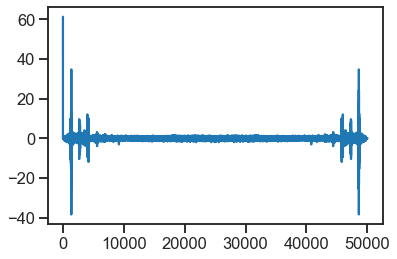

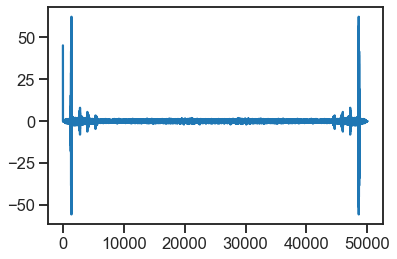

In [82]:
figure()
plot(_fft_call_mic0)

figure()
plot(_fft_call_mic1)

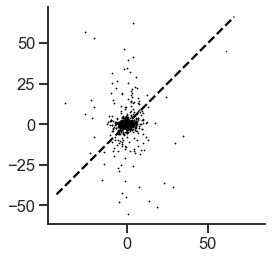

In [84]:
plot(_fft_call_mic0, _fft_call_mic1, '.k', markersize=1)
x = np.linspace(xlim()[0], xlim()[1])
plot(x,x, 'k--')
axis('square')

sns.despine()

In [104]:
fft_r2 = []
for i in range(10000):
    call_padded = np.append(call_mic1, [0]*i)[i:]
    working_fft_call_mic1 = np.fft.fft(call_padded)
    slope, intercept, r_value, p_value, std_err = linregress(call_padded, np.fft.fft(call_mic0))
    fft_r2.append(r_value**2)

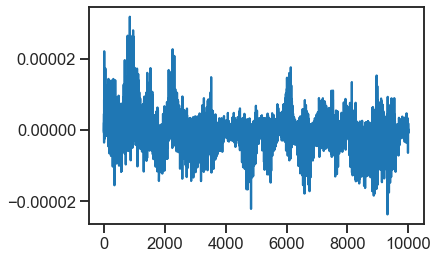

In [105]:
plot(fft_r2)

In [107]:
fft_r2 = []
for i in range(10000):
    call_padded = np.append(call_mic0, [0]*i)[i:]
    working_fft_call_mic0 = np.fft.fft(call_padded)
    slope, intercept, r_value, p_value, std_err = linregress(call_padded, np.fft.fft(call_mic1))
    fft_r2.append(r_value**2)

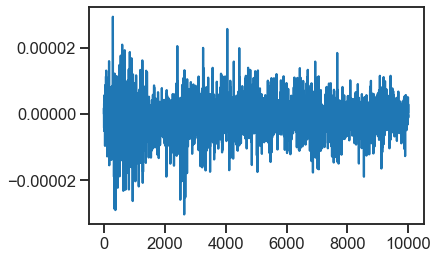

In [108]:
plot(fft_r2)

# fft bandpass 

In [109]:
fft_r2 = []
for i in range(10000):
    call_padded = np.append(call_mic1_bp, [0]*i)[i:]
    working_fft_call_mic1 = np.fft.fft(call_padded)
    slope, intercept, r_value, p_value, std_err = linregress(call_padded, np.fft.fft(call_mic0_bp))
    fft_r2.append(r_value**2)

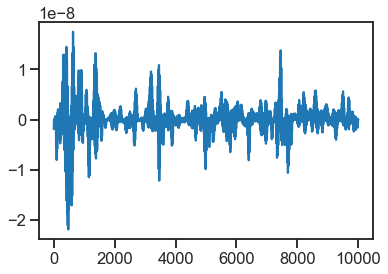

In [110]:
plot(fft_r2)

In [111]:
fft_r2 = []
for i in range(10000):
    call_padded = np.append(call_mic0_bp, [0]*i)[i:]
    working_fft_call_mic0 = np.fft.fft(call_padded)
    slope, intercept, r_value, p_value, std_err = linregress(call_padded, np.fft.fft(call_mic1_bp))
    fft_r2.append(r_value**2)

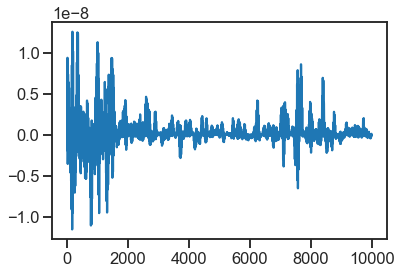

In [112]:
plot(fft_r2)